# <img src="https://img.icons8.com/bubbles/100/000000/3d-glasses.png" style="height:50px;display:inline"> EE 046746 - Technion - Computer Vision

#### Tal Daniel

## Tutorial 11 - Deep Object Detection
---

<img src="./assets/tut_objdet_detection.png" style="height:300px">

* <a href="https://sigmoidal.io/dl-computer-vision-beyond-classification/">Image Source</a>

### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Agenda
---

* [What is the Object Detection/Recognition Task?](#-Image-Classifcation-+-Object-Localization-=-Object-Detction)
    * [Image Classifcation + Object Localization = Object Detction](#-Image-Classifcation-+-Object-Localization-=-Object-Detction)
    * [Localization Approaches](#-Localiztion-Approaches)
        * Sliding Windows Approach
    * [Performance Metrics](#-Performance-Metrics)
* [Region-based Convolutional Neural Networks (R-CNN) Family](#-Region-based-Convolutional-Neural-Networks-(R-CNN)-Family)
* [You Only Look Once (YOLO) Family](#-You-Only-Look-Once-(YOLO)-Family)
* [Single Shot Multibox Detection (SSD)](#-Single-Shot-Multibox-Detection-(SSD))
* [Which Algorithm to Use???](#-Which-Algorithm-to-Use?)
* [Recommended Videos](#-Recommended-Videos)
* [Credits](#-Credits)

In [1]:
# imports for the tutorial
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import torch
from models.yolov3.detect import yolov3_detect

## <img src="https://img.icons8.com/color/96/000000/frame.png" style="height:50px;display:inline"> What Is Object Detection/Recognition?
---
* In this tutorial we are going to get familiar with one of the most popular and challenging tasks in Computer Vision - Object Detection (or Object Recognition). 
* It is sometimes hard to distinguish between different related computer vision tasks. For example, classification vs. localization, detection vs. tracking and etc...

### <img src="https://img.icons8.com/dusk/64/000000/plus.png" style="height:50px;display:inline"> Image Classifcation + Object Localization = Object Detction
---
* **Image classification** takes an image and predicts the object in an image. For example, when we build a cat-dog classifier, we take images of cat or dog and predict their class:
<img src="./assets/tut_objdet_dog.jpg" style="height:200x">
* *Input*: An image with a single object, such as a photograph.
* *Output*: A class label (e.g. one or more integers that are mapped to class labels).

* But what if both classes are present in the image? What would be the model's prediction?
<img src="./assets/tut_objdet_catdog.jpeg" style="height:200px">

* To solve this problem we can train a multi-label classifier which will predict all the possible classes (dog, cat, dog-and-cat). 
* **Object localization** - we still don't know the *location* of the cat or the dog. The problem of identifying the location of an object (given the class) in an image is called **localization**. 
    * If the object class is not known, we have to predict both the location and the class of each object!
<img src="./assets/tut_objdet_cat.png" style="height:200px">
* *Input*: An image with one or more objects, such as a photograph.
* *Output*: One or more bounding boxes (e.g. defined by a point, width, and height).

* **Object detection** - predicting the location of the object along with the class is called object detection. 
* Instead of predicting the class of object from an image, we now have to predict the class as well as a rectangle (called *bounding box*) containing that object.
* So, image classification involves assigning a class label to an image, whereas object localization involves drawing a bounding box around one or more objects in an image. 
* Object detection is more challenging and combines these two tasks and draws a bounding box around each object of interest in the image and assigns them a class label. Together, all of these problems are referred to as object recognition.

<img src="./assets/tut_objdet_diagram.png" style="height:300px">

* It takes 4 variables to uniquely identify a rectangle. So, for each instance of the object in the image, we shall predict following variables:
    * `class_name`
    * `bounding_box_top_left_x_coordinate`
    * `bounding_box_top_left_y_coordinate`
    * `bounding_box_width`
    * `bounding_box_height`

### <img src="https://img.icons8.com/clouds/100/000000/google-maps.png" style="height:50px;display:inline"> Localization Approaches
---
* **Classic Sliding Window** approach
* **Region-Based Convolutional Neural Networks**, or R-CNNs -  a family of techniques for addressing object localization and recognition tasks, designed for model performance. Region proposal + classification approach.
* **You Only Look Once**, or YOLO, is a second family of techniques for object recognition designed for speed and real-time use. Regression approach.

#### Sliding Window
* Object Detection is modeled as a classification problem where we take windows of fixed sizes from input image at all the possible locations feed these patches to an image classifier.
<img src="./assets/tut_objdet_sliding.gif" style="height:250px">

* Each window is fed to the classifier which predicts the class of the object in the window (or background if none is present).
* **Problem** - how do you know the size of the window so that it always contains the image?
<img src="./assets/tut_objdet_small_big_obj.PNG" style="height:200px">

* As you can see that the object can be of varying sizes. 
* To solve this problem an **image pyramid** is created by scaling the image.
    * The idea is to resize the image at multiple scales and rely on the fact that our chosen window size will completely contain the object in *one* of these resized images.
* Most commonly, the image is downsampled (size is reduced) until a certain condition, typically a minimum size, is reached.
* A fixed size window detector is run on each of these images.
* It’s common to have as many as 64 levels on such pyramids. Now, all these windows are fed to a classifier to detect the object of interest.

* This approach can be very expensive computationally, and thus **very slow**.
<img src="./assets/tut_objdet_pyramid.PNG" style="height:250px">

## <img src="https://img.icons8.com/clouds/100/000000/performance-2.png" style="height:50px;display:inline"> Performance Metrics
---
* How can we tell if the *predicted* bounding box is good with respect to the *ground truth* (labeled) bounding box?
* Two popular evaluation metrics are the **intersection over union (IoU)** and **Average Precision (AP)**

### Intersection over Union (IoU)
---
* Also called the *Jaccard Index*.
* A value between 0 and 1. 
* It corresponds to the overlapping area between the predicted mask and the ground-truth mask. 
* The **higher** the IoU, the better the predicted location of the box for a given object.
* The segmentation challenge is evaluated using the **mean Intersection over Union (mIoU)** metric.
    * The mIoU is the average between the IoU of the segmented objects over all the images of the test dataset.
* $$ IoU = \frac{TP}{TP + FP+ FN} = \frac{\mid X \cap Y \mid}{\mid X \mid + \mid Y \mid - \mid X \cap Y \mid} $$
    * $X$ and $Y$ are the predicted and ground truth segmentation, respectively.
    * TP is the true positives, FP false positives and FN false negatives.
* Typical threshold for detection: 0.5

<img src="./assets/tut_seg_iou.png" style="height:200px">

* Image Source: Wikipedia

### Average Precision (AP)
---
* In binary classification, the Average Precision (AP) metric is a summary of the precision-recall curve.
* The **mean Average Precision (mAP)** is the mean of the Average Precisions computed over *all the classes* of the challenge.
* The mAP metric avoids to have extreme specialization in few classes and thus weak performances in others.
* Let $Q$ be the number of classes, $P$ denotes the precision ($P = \frac{TP}{TP+FP}$), and $AvgP(q)$ is the average precision of the $q^{th}$ category: $$mAP = \frac{\sum_{q=1}^Q AvgP(q)}{Q} $$

## <img src="https://img.icons8.com/nolan/64/zoom-region-mode.png" style="height:50px;display:inline"> Region-based Convolutional Neural Networks (R-CNN) Family
---
* The problem with combining CNNs with the sliding window approach is that CNNs are too slow and computationally very expensive. It is practically impossible to run CNNs on so many patches generated by a sliding window detector.
* The R-CNN family of methods refers to the R-CNN, which may stand for “Regions with CNN Features” or “Region-Based Convolutional Neural Network,” developed by Ross Girshick, et al.
* This includes the techniques **R-CNN**, **Fast R-CNN**, and **Faster-RCNN** designed and demonstrated for object localization and object recognition.

### <img src="https://img.icons8.com/color/96/000000/region-code.png" style="height:30px;display:inline"> R-CNN
---
* The R-CNN was introduced in the 2014 paper by Ross Girshick, et al. from UC Berkeley titled <a href="https://arxiv.org/abs/1311.2524">“Rich feature hierarchies for accurate object detection and semantic segmentation</a>.
* It may have been one of the first large and successful application of convolutional neural networks to the problem of object localization, detection, and segmentation.
* The approach was demonstrated on benchmark datasets, achieving then state-of-the-art results on the VOC-2012 dataset and the 200-class ILSVRC-2013 object detection dataset. We presented these datasets in the *Segmentation* tutorial.

* The R-CNN model is comprised of three modules:
    * **Module 1: Region Proposal** - generate and extract category independent region proposals, e.g. candidate bounding boxes.
    * **Module 2: Feature Extractor** - extract feature from each candidate region, e.g. using a deep convolutional neural network.
    * **Module 3: Classifier** - classify features as one of the known class, e.g. linear SVM classifier model.

<img src="./assets/tut_objdet_rcnn.png" style="height:250px">

#### Module 1 -  Region Proposal
* **Selective Search** - a *classic* computer vision technique that is used to propose candidate regions or bounding boxes of potential objects in the image.
    * *Stage 1* - calculate initial regions.
    * *Stage 2* - group regions with the highest similarity - repeat.
    * *Stage 3* - generate a hierarchy of bounding boxes.
* Selective search uses local cues like texture, intensity, color and/or a measure of insideness and etc to generate all the possible locations of the object.
<img src="./assets/tut_objdet_selective_search.jpg" style="height:200px">
* <a href="http://www.huppelen.nl/publications/selectiveSearchDraft.pdf">Image Source</a>

#### Module 2 - Feature Extractor
* A feature vector of 4,096 dimensions is extracted *for each* object proposal using a **CNN**.
* The feature extractor used by the model was the AlexNet deep CNN that won the ILSVRC-2012 image classification competition.
* **Problem** - the input of the CNN should be a fixed size (224x224) but the size of each proposal *is different*.
    * The size of the objects must be changed to a fixed size!
    * **Solution** - use *warping* - anisotropically scales the object proposals (different scale in two directions).
* The choice of the **CNN architecture** has a large effect on the detection performance (obviously...).

<img src="./assets/tut_objdet_warp.PNG" style="height:250px">

#### Module 3 - Classifier
* The output of the CNN was a 4,096 element vector that describes the contents of the image that is fed to a linear SVM for classification, specifically one SVM is trained for each known class.
* Why use SVM and not a *Softmax* layer? It *empirically* works better.

<img src="./assets/tut_objdet_svm.PNG" style="height:200px">

#### Training R-CNNs
* **Training the CNN**:
    * R-CNNs uses pre-trained CNNs, usually on pre-trained image-level (not object level) annotations.
    * Adapting the CNN to detection and to the new domain (warped proposal windows), by training with SGD (Stochastic Gradient Descent).
        * Uses proposals with $IoU > 0.5$ as positive examples (the rest are negative). Recall that this is a supervised task, and thus we have the ground-truth bounding boxes.
* **Training the SVM**:
    * Uses proposals with $IoU < 0.3$ as negative examples and ground truth regions as positive examples.
        * Why is it different than the CNN threshold? It *empirically* works better and reduces *overfitting*.

#### Detecting Objects with R-CNNs
* At test time, **non-maximum suppression (NMS)** is applied greedily given all scored regions in an image.
* **Non-Maximum Supression (NMS)** - a technique which filters the proposals based on some threshold value (rejects proposals).
    * *Input*: A list of Proposal boxes $B$, corresponding confidence scores $S$ and overlap threshold $N$.
    * *Output*: A list of filtered proposals $D$.
<img src="./assets/tut_objdet_nms.png" style="height:200px">
* <a href="https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c">Source and Read More</a>

#### Drawbacks of R-CNN
* Training is not end-to-end, but a *multi-stage* pipeline.
* Trainning is computationally expensive in space and time (training a deep CNN on so many region proposals per image is very slow).
* At test-time object-detection is slow, requiring a CNN-based feature extraction to pass on each of the candidate regions generated by the region proposal algorithm.

<img src="./assets/tut_objdet_rcnn2.jpg" style="height:250px">

### <img src="https://img.icons8.com/bubbles/50/000000/fast-forward.png" style="height:40px;display:inline"> Fast R-CNNs
---
* Given the great success of R-CNN, Ross Girshick, proposed an extension to address the speed issues of R-CNN in a 2015 paper titled <a href="https://arxiv.org/abs/1504.08083">“Fast R-CNN”</a>.
* Fast R-CNN is proposed as a **single-stage** model instead of a pipeline to learn and output regions and classifications *directly*.
* Fast RCNN added a **bounding box regression** to the neural network training itself. 
    * Now the network has two heads, classification head, and bounding box regression head.

* The architecture of the model takes the photograph and a set of region proposals (from a selective search) as input that are passed through a deep convolutional neural network.
* A pre-trained CNN, such as a VGG-16, is used for feature extraction. 
* The end of the deep CNN is a custom layer called a **Region of Interest Pooling** Layer, or **RoI Pooling**, that extracts features specific for a given input candidate region.

<img src="./assets/tut_objdet_roi1.PNG" style="height:300px">

<img src="./assets/tut_objdet_roi2.png" style="height:250px">

* <a href="https://deepsense.ai/region-of-interest-pooling-in-tensorflow-example/">Image Source</a>

* The output of the CNN is then interpreted by a fully connected layer then the model has two outputs, one for the **class prediction** via a Softmax layer, and another with a linear output for the **bounding box**. 
* This process is then repeated multiple times for each region of interest in a given image.

<img src="./assets/tut_objdet_faster_rcnn.png" style="height:250px">

* The model is **significantly faster** to train and to make predictions, yet still requires a set of candidate regions to be proposed along with each input image.
    * Faster detection with **Truncated SVD** - compresses the fully-connected layers and reduces detection time by more than 30\% with only a small drop in mAP. 

### <img src="https://img.icons8.com/dusk/64/000000/the-flash-sign.png" style="height:40px;display:inline"> Faster R-CNNs
---
* The *slowest* part in Fast RCNN was **Selective Search** or Edge boxes.
* The Fast RCNN model architecture was further improved for both speed of training and detection by Shaoqing Ren, et al. in the 2016 paper titled <a href="https://arxiv.org/abs/1506.01497">“Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks”</a>.
* The architecture was the basis for the *first-place* results achieved on both the ILSVRC-2015 and MS COCO-2015 object recognition and detection competition tasks.
* The idea was to replace selective search with a very small convolutional network called **Region Proposal Network** to generate regions of Interests.

<img src="./assets/tut_objdet_faster_rcnn_arch.png" style="height:350px">

* The architecture was designed to both **propose and refine** region proposals as part of the training process, referred to as a **Region Proposal Network, or RPN**. 
* These regions are then used in concert with a *Fast R-CNN* model in a single model design. 
* These improvements both reduce the number of region proposals and accelerate the test-time operation of the model to near real-time with then state-of-the-art performance.

* The architecture is comprised of two modules:
    * **Module 1: Region Proposal Network** - CNN for proposing regions and the type of object to consider in the region.
    * **Module 2: Fast R-CNN** - CNN for extracting features from the proposed regions and outputting the bounding box and class labels.
* Both modules operate on the **same output of a deep CNN**. 
* The region proposal network acts as an *attention* mechanism for the Fast R-CNN network, informing the second network of where to look or pay attention.

* The RPN works by taking the output of a pre-trained deep CNN, such as VGG-16, and passing a small network over the feature map and outputting multiple region proposals and a class prediction for each. 
* Region proposals are *bounding boxes*, based on so-called **anchor boxes** or pre-defined shapes designed to accelerate and improve the proposal of regions. 
* The class prediction is binary, indicating the presence of an object, or not, so-called “objectness” of the proposed region.

* RPN Steps:
    * Generate (pre-defined) anchor boxes.
    * Feed the possible regions into the RPN and classify each anchor box whether it is foreground or background (anchors that have a higher overlap with ground-truth boxes should be labeled as foreground, while others should be labeled as background).
    * The output is fed into a Softmax or logistic regression activation function, to predict the labels for each anchor. A similar process is used to refine the anchors and define the bounding boxes for the selected features (learn the shape offsets for anchor boxes to fit them for objects).

<img src="./assets/tut_objdet_rpn_1.PNG" style="height:250px">

* <a href="https://towardsdatascience.com/region-proposal-network-a-detailed-view-1305c7875853">Image Source and Read More (1)</a>

<img src="./assets/tut_objdet_rpn_2.jpeg" style="height:400px">

* <a href="https://medium.com/@smallfishbigsea/faster-r-cnn-explained-864d4fb7e3f8">Image Source and Read More (2)</a>

* Faster-RCNN is 10 times faster than Fast-RCNN with similar accuracy of datasets like VOC-2007. 
* That is why Faster-RCNN is one of the most accurate object detection algorithms.

| |R-CNN|Fast R-CNN|Faster R-CNN |
|--|----|----------|-------------|
|Test Time Per Image (sec)|50|2|0.2|
|Spped Up|1x|25x|250x|

<img src="./assets/tut_objdet_rcnn-family-summary.png" style="height:300px">

* <a href="https://lilianweng.github.io/lil-log/2017/12/31/object-recognition-for-dummies-part-3.html">Image Source</a>

### <img src="https://img.icons8.com/cotton/64/000000/olympic-torch.png" style="height:50px;display:inline"> R-CNN Family Implementations
---
* R-CNN, Fast R-CNN, Faster R-CNN and even Mask R-CNN are all implemented in **Detectron2 for PyTorch**.
    * It is better to use Faster R-CNN or Mask R-CNN (if you need segmentation).
* <a href="https://github.com/facebookresearch/detectron2">Detectron2 for PyTorch</a>
    * <a href="https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5">Colab Notebook Demo of Detectron2</a>
    
<img src="./assets/tut_objdet_detectron.png" style="height:300px">

## <img src="https://img.icons8.com/cotton/64/000000/opera-glasses.png" style="height:50px;display:inline"> You Only Look Once (YOLO) Family
---
* All the methods discussed above handled detection as a classification problem by building a pipeline where first object proposals are generated and then these proposals are sent to classification/regression heads.
* Another popular family of object recognition models is referred to collectively as YOLO or “You Only Look Once,” developed by Joseph Redmon, et al. which is a **regression**-based detection method.
* The R-CNN models may be generally *more accurate*, yet the YOLO family of models are *fast*, much faster than R-CNN, achieving object detection in *real-time*.
* <a href="https://pjreddie.com/darknet/yolo/">YOLO Official Website</a>

### <img src="https://img.icons8.com/cute-clipart/64/000000/visible.png" style="height:30px;display:inline"> YOLO (v1)
---
* The YOLO model was first described by Joseph Redmon, et al. in the 2015 paper titled <a href="https://arxiv.org/abs/1506.02640">“You Only Look Once: Unified, Real-Time Object Detection”</a>.
* The approach involves a **single neural network** trained end-to-end that takes a photograph as input and predicts bounding boxes and class labels for each bounding box directly.
* The technique offers lower predictive accuracy (e.g. more localization errors), although operates at 45 frames per second and up to 155 frames per second for a speed-optimized version of the model.

* The model works by first splitting the input image into a **grid of cells**, where each cell is responsible for predicting a bounding box if the center of a bounding box falls within it.
    * YOLO divides each image into a grid of $S \times S$ and each grid cell predicts $N$ (usually $N=2$) bounding boxes and confidence where a bounding box involving the $x, y$ coordinate, the width, the height and the confidence. 
    * The confidence reflects the accuracy of the bounding box and whether the bounding box actually contains an object (regardless of class).
        * YOLO uses Non-Maximal Suppression (NMS) to only keep the best bounding box. The first step in NMS is to remove all the predicted bounding boxes that have a detection probability that is less than a given NMS threshold.
    * YOLO also predicts the classification score for each box for every class in training.
    * A total $S\times S \times N$ boxes are predicted. However, most of these boxes have low confidence scores.

<img src="./assets/tut_objdet_yolo.png" style="height:350px">

<img src="./assets/tut_objdet_yolo_arch.png" style="height:250px">

* $B$ is the number of bounding boxes from each cell, $C$ is the number of classes.
* <a href="https://lilianweng.github.io/lil-log/2018/12/27/object-detection-part-4.html#yolo-you-only-look-once">Image Source</a>

* In test time, the test image is first broken up into a grid and the network then produces output vectors, one for each grid cell. 
* These vectors tell us if a cell has an object in it, what class the object is, and the bounding boxes for the object. 
    * Since we’re using two anchor boxes, we’ll get two predicted anchor boxes for each grid cell. Some, in fact most of the predicted anchor boxes will have a very low probability value of object being present in it.
* After producing these output vectors, non-maximal suppression is used to get rid of unlikely bounding boxes. 
    * For each class, non-maximal suppression gets rid of the bounding boxes that have a confidence value lower than some given threshold.

### <img src="https://img.icons8.com/dusk/64/000000/visible.png" style="height:30px;display:inline"> YOLO v2 & v3
---
* The model was updated by Joseph Redmon and Ali Farhadi in an effort to further improve model performance in their 2016 paper titled <a href="https://arxiv.org/abs/1612.08242">"YOLO9000: Better, Faster, Stronger"</a>.
* Further improvements to the model were proposed by Joseph Redmon and Ali Farhadi in their 2018 paper titled <a href="https://arxiv.org/abs/1804.02767">"YOLOv3: An Incremental Improvement"</a>. The improvements were reasonably minor, including a deeper feature detector network and minor representational changes.

#### Main Improvements
* YOLOv2 - an instance of the model is described that was trained on two object recognition datasets in parallel, capable of predicting 9,000 object classes, hence given the name "YOLO9000", and later reffered to as "YOLOv2".
* A number of training and architectural changes were made to the model, such as the use of batch normalization and high-resolution input images.
* Like Faster R-CNN, YOLOv2 model makes use of **anchor boxes**, pre-defined bounding boxes with useful shapes and sizes that are tailored during training. 
    * The choice of bounding boxes for the image is pre-processed using a k-means analysis on the training dataset.
* The predicted representation of the bounding boxes is changed to allow *small changes to have a less dramatic effect* on the predictions, resulting in a more stable model.
* Rather than predicting position and size directly, **offsets** are predicted for moving and reshaping the pre-defined anchor boxes relative to a grid cell and dampened by a logistic function.

* Example of the Representation Chosen when Predicting Bounding Box Position and Shape:
<img src="./assets/tut_objdet_yolov2.png" style="height:350px">

* At runtime, the image is propagated through the CNN only once. 
* Hence, YOLO is super fast and can be run real time. 
* Another key difference is that YOLO sees the complete image at once as opposed to looking at only a generated region proposals in the previous methods. 
    * This contextual information helps in avoiding false positives. 
* However, one limitation for YOLO is that it only predicts one type of class in one grid cell. Hence, it struggles with very small objects.
* <a href="https://github.com/ultralytics/yolov3">YOLOv3 PyTorch Code</a>
    * <a href="https://github.com/eriklindernoren/PyTorch-YOLOv3">Another PyTorch Code</a>

# ------------------------- <img src="https://img.icons8.com/color/96/000000/code.png" style="height:50px;display:inline"> CODE TIME -------------------------

* We will use the first code we provided (`YOLOv3 PyTorch Code`).
* Download the weights from <a href="https://drive.google.com/drive/folders/1LezFG5g3BCW6iYaV89B2i64cqEUZD7e0">this link</a>
    * We use `yolov3-spp-ultralytics.pt`, but you can try different ones.
* Place it in the `weights` folder under the model directory (`yolov3`)

In [5]:
help(yolov3_detect)

Help on function yolov3_detect in module models.yolov3.detect:

yolov3_detect(img_source, img_size=416, save_img=False, device=device(type='cpu'), cfg='./models/yolov3/cfg/yolov3-spp.cfg', names='./models/yolov3/data/coco.names', classes=None, weights='./models/yolov3/weights/yolov3-spp-ultralytics.pt', output='./models/yolov3/output', conf_thresh=0.3, iou_thresh=0.6, fourcc='mp4v', half=False, view_img=False, save_txt=False, agnostic_nms=False)



image 1/1 models\yolov3\data\samples\bus.jpg: 416x320 4 persons, 1 buss, Done. (0.065s)
Results saved to C:\Users\tabad\AnacondaWorkspace\Computer Vision\ee046746-computer-vision\./models/yolov3/output
Done. (0.127s)


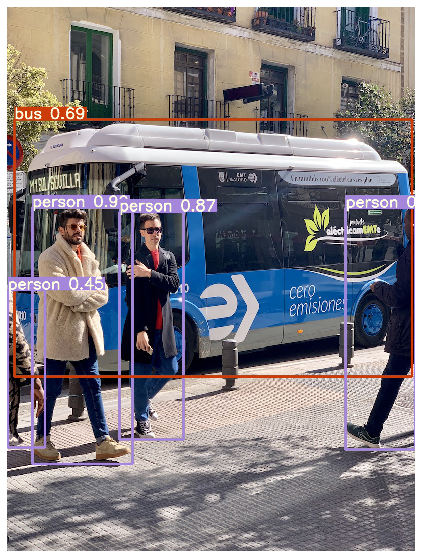

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
img_src = './models/yolov3/data/samples/bus.jpg'
output = './models/yolov3/output/bus.jpg'
yolov3_detect(img_src, device=device)

# show image
img = cv2.cvtColor(cv2.imread(output), cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(img)
ax.set_axis_off()

### <img src="https://img.icons8.com/bubbles/50/000000/all-4.png" style="height:40px;display:inline"> YOLO v4
---
* In 2020, a major improvement to the YOLO model was intorduced in the paper <a href="https://arxiv.org/abs/2004.10934">YOLOv4: Optimal Speed and Accuracy of Object Detection</a>.
* YOLOv4’s architecture is composed of CSPDarknet53 (CSP: Cross-Stage-Partial connections, separating the current layer into 2 parts, one that will go through a block of convolutions, and one that won’t and then aggregate the results) as a **backbone**, spatial pyramid pooling additional module, PANet path-aggregation **neck** and **YOLOv3 head**.
* Bag-Of-Freebies (BoF) and Bag-Of-Specials (BoS) - more improvements such as augementations, regularizations and special activations.
* <a href="https://github.com/Tianxiaomo/pytorch-YOLOv4">YOLOv4 PyTorch Code<a/>

* A typical object detection architecture:
<img src="./assets/tut_objdet_yolov4arch.png" style="height:250px">

* YOLO is a **One-Stage-Detector**, while the R-CNN family is a **Two-Stage-Detector** (since in a region proposal network, you look at the image in two steps—the first to identify regions where there might be objects, and the next to specify it).
* Backbone - CSPDarknet53 is a novel backbone that can enhance the learning capability of CNN. The backbone is simply feature extraction (the backbone can be replaced with VGG, ResNet and etc...).
* Neck - The spatial pyramid pooling block is added over CSPDarknet53 to increase the receptive field and separate out the most significant context features. 
* Neck - Instead of Feature Pyramid Networks (FPN) for object detection used in YOLOv3, the PANet is used as the method for parameter aggregation for different detector levels (aggregate information to get higher accuracy).
* Head - the same process as in YOLOv3. The network detects the bounding box coordinates $(x,y,w,h)$ as well as the confidence score for a class (anchor-based technique).

<img src="./assets/tut_objdet_yolov4res.png" style="height:300px">

* AP (Average Precision) and FPS (Frames Per Second) increased by 10% and 12% compared to YOLOv3

# ------------------------- <img src="https://img.icons8.com/color/96/000000/code.png" style="height:50px;display:inline"> CODE TIME -------------------------

In [2]:
%cd models/yolov4/
from demo import yolov4_detect

C:\Users\tabad\AnacondaWorkspace\Computer Vision\ee046746-computer-vision\models\yolov4


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
img_src = '../yolov3/data/samples/bus.jpg'
output = './predictions.jpg'
yolov4_detect('./cfg/yolov4.cfg', './weights/yolov4.weights', img_src, device)

# show image
img = cv2.cvtColor(cv2.imread(output), cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(img)
ax.set_axis_off()

## <img src="https://img.icons8.com/bubbles/50/000000/screenshot.png" style="height:50px;display:inline"> Single Shot Multibox Detection (SSD)
---
* A *regression* type object detector which was introduced by Liu et al. in 2016 in a paper titled <a href="https://arxiv.org/abs/1512.02325">"SSD: Single Shot MultiBox Detector"</a>.
* Single-shot models encapsulate both localization and detection tasks in a single forward sweep of the network, resulting in significantly faster detections while deployable on lighter hardware.
* Single Shot Detector achieves a good balance between speed and accuracy. 

* SSD has two components: a **backbone model** and **SSD** head. 
    * **Backbone model** usually is a pre-trained image classification network as a feature extractor. This is typically a network like ResNet trained on ImageNet from which the final fully connected classification layer has been removed. 
    * **The SSD** head is just one or more convolutional layers added to this backbone and the outputs are interpreted as the bounding boxes and classes of objects in the spatial location of the final layers activations.

<img src="./assets/tut_objdet_ssd_arch.png" style="height:250px">

* SSD runs a convolutional network on input image only once and calculates a feature map. 
* Then, a small $3 \times 3$ sized convolutional kernel is run on this feature map to predict the bounding boxes and classification probability. 
* SSD also uses **anchor boxes** at various aspect ratio similar to Faster-RCNN and learns the offset rather than learning the box. 
* In order to handle the scale, SSD predicts bounding boxes after multiple convolutional layers. Since each convolutional layer operates at a different scale, it is able to detect objects of various scales.

* Unlike YOLO, SSD does not split the image into grids of *arbitrary* size but predicts offset of predefined anchor boxes for every location of the feature map. 
    * Each box has a fixed size and position relative to its corresponding cell. All the anchor boxes tile the whole feature map in a convolutional manner.
* The extra step taken by SSD is that it applies **more convolutional layers to the backbone feature map** and has each of these convolution layers output a object detection results. 
* As earlier layers bearing smaller receptive field can represent smaller sized objects, predictions from earlier layers help in dealing with smaller sized objects.
* <a href="https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Detection/SSD">SSD PyTorch Code (NVIDIA)</a>
    * <a href="https://github.com/amdegroot/ssd.pytorch">Another PyTorch Code</a>

<img src="./assets/tut_objdet_ssd_2.PNG" style="height:350px">

* <a href="https://d2l.ai/chapter_computer-vision/ssd.html">Image Source</a>

# ------------------------- <img src="https://img.icons8.com/color/96/000000/code.png" style="height:50px;display:inline"> CODE TIME -------------------------

* We will use Nvidia's model which is available in the <a href="https://pytorch.org/hub/nvidia_deeplearningexamples_ssd/">PyTorch Hub</a>.
* Feel free to download the original model from the provided links to get a look at the training procedure.
* Note: the original model uses `skimage` to load and transform images, which may results in errors because it is deprecated, so just go to `hubconf.py` (where the model was downloaded) and change `skimage` to `cv2`.
    * `img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) / 255.0`
    * `imgScaled = cv2.resize(img, (input_width, res))`

In [2]:
# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# load the model from the hub
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math='fp32').to(device)
# load utils
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')
# change to evaluation mode
ssd_model.eval();

cuda:0


Using cache found in C:\Users\tabad/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
Using cache found in C:\Users\tabad/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


In [3]:
img_src = ['./models/yolov3/data/samples/bus.jpg']
# load and convert to tensors
inputs = [utils.prepare_input(img) for img in img_src]
inputs_t = utils.prepare_tensor(inputs)
# predict
with torch.no_grad():
    detections_batch = ssd_model(inputs_t)

By default, raw output from SSD network per input image contains 8732 boxes with localization and class probability distribution. Let’s filter this output to only get reasonable detections (confidence>40%) in a more comprehensive format.

In [6]:
results_per_input = utils.decode_results(detections_batch)
best_results_per_input = [utils.pick_best(results, 0.40) for results in results_per_input]

The model was trained on COCO dataset, which we need to access in order to translate class IDs into object names. For the first time, downloading annotations may take a while.

In [7]:
classes_to_labels = utils.get_coco_object_dictionary()

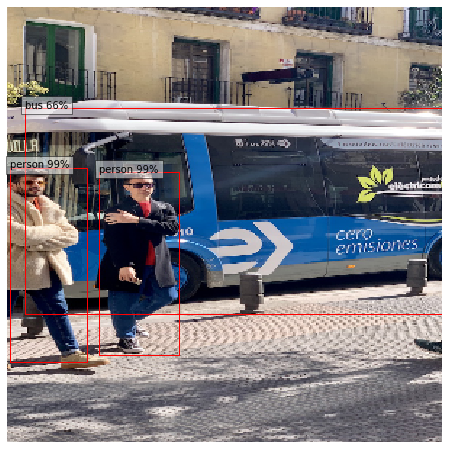

In [11]:
# visualize the results
for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1, figsize=(8, 8))
    # show original, denormalized image
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)
    # add detections
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100),
                bbox=dict(facecolor='white', alpha=0.5))
        ax.set_axis_off()

### <img src="https://img.icons8.com/nolan/50/question-mark.png" style="height:50px;display:inline"> Which Algorithm to Use?
---
* Choice of a right object detection method is crucial and depends on the problem you are trying to solve and the set-up. 
* Object Detection is the backbone of many practical applications of computer vision such as autonomous cars, security and surveillance, and many industrial applications.
* **Faster-RCNN** is the choice if you mostly care about the accuracy numbers. 
* **SSD** provides good balance between performance and speed. 
* **YOLO** is super fast but on the account of performance.

<img src="./assets/tut_objdet_speed.jpg" style="height:300px">

<img src="./assets/tut_objdet_size.png" style="height:300px">

### <img src="https://img.icons8.com/bubbles/50/000000/video-playlist.png" style="height:50px;display:inline"> Recommended Videos
---
#### <img src="https://img.icons8.com/cute-clipart/64/000000/warning-shield.png" style="height:30px;display:inline"> Warning!
* These videos do not replace the lectures and tutorials.
* Please use these to get a better understanding of the material, and not as an alternative to the written material.

#### Video By Subject
* (Deep) Object Detection - <a href="https://www.youtube.com/watch?v=nDPWywWRIRo"> Stanford CS231 - Lecture 11 | Detection and Segmentation</a>
* Object Detection - <a href="https://www.youtube.com/watch?v=5e5pjeojznk&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=26&t=0s">C4W3L03 Object Detection - Andrew Ng</a>
* Non-Maximum Supression - <a href="https://www.youtube.com/watch?v=VAo84c1hQX8&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=29&t=0s">C4W3L07 Nonmax Suppression - Andrew Ng</a>
* Region Proposals - <a href="https://www.youtube.com/watch?v=6ykvU9WuIws&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=32&t=0s">C4W3L10 Region Proposals - Andrew Ng</a>
* R-CNN, Fast R-CNN, Faster R-CNN - <a href="https://www.youtube.com/watch?v=a9_8wqMxVkY">RCNN, FAST RCNN, FASTER RCNN : OBJECT DETECTION AND LOCALIZATION THROUGH DEEP NEURAL NETWORKS</a>
* YOLO - <a href="https://www.youtube.com/watch?v=9s_FpMpdYW8&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=31&t=0s">C4W3L09 YOLO Algorithm - Andrew Ng</a>
* YOLO v3 - <a href="https://www.youtube.com/watch?time_continue=1&v=MPU2HistivI&feature=emb_logo">YOLOv3</a>
* YOLO v4 - <a href="https://www.youtube.com/watch?v=_JzOFWx1vZg">Yolo V4 - How it Works and Why it's So Amazing!</a>
* SSD - <a href="https://www.youtube.com/watch?v=JuLuTzZLBmI">Single shot detectors - training</a>

## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
---
* <a href="https://cv-tricks.com/object-detection/faster-r-cnn-yolo-ssd/">Zero to Hero: Guide to Object Detection using Deep Learning: Faster R-CNN,YOLO,SSDO - Ankit Sachan</a>
* <a href="https://machinelearningmastery.com/object-recognition-with-deep-learning/">A Gentle Introduction to Object Recognition With Deep Learning - Jason Brownlee</a>
* <a href="https://developers.arcgis.com/python/guide/how-ssd-works/">
How single-shot detector (SSD) works?</a>
* <a href="https://towardsdatascience.com/whats-new-in-yolov4-323364bb3ad3">What’s new in YOLOv4?</a>
* <a href="https://heartbeat.fritz.ai/introduction-to-yolov4-research-review-5b6b4bd5f255">Introduction to YOLOv4: Research review</a>
* Slides by David Dov and Yael Amiay.
* Icons from <a href="https://icons8.com/">Icon8.com</a> - https://icons8.com